# Xylan degradation

In this notebook we will explore xylan production in Bascillus subtilis 168

In [3]:
from spamdfba import toolkit as tk
import cobra
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import pickle
import os
import warnings
import rich
import multiprocessing as mp
import json
import plotly.graph_objects as go
from plotly.subplots import make_subplots

2024-05-18 08:54:33,767	INFO worker.py:1724 -- Started a local Ray instance.


First we have to load the metabolic model of Bascillus subtilis 168, which is available in the BiGG database. Run below to download the model.


In [2]:
# !wget http://bigg.ucsd.edu/static/models/iYO844.json.gz
#! gzip -d iYO844.json.gz

In [2]:
from collections import Counter

Now let's load the model.

In [4]:
bacillus_model=cobra.io.load_json_model('./iYO844.json')

Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-18


We have two genes known for xylan breakdown in Bascillus subtilis 168:

Endo-1,4-beta-xylanase A:P18429

Beta-xylosidase: P94489

In [5]:
P18429="MFKFKKNFLVGLSAALMSISLFSATASAASTDYWQNWTDGGGIVNAVNGSGGNYSVNWSNTGNFVVGKGWTTGSPFRTINYNAGVWAPNGNGYLTLYGWTRSPLIEYYVVDSWGTYRPTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATEGYQSSGSSNVTVW"
P94489="MKITNPVLKGFNPDPSICRAGEDYYIAVSTFEWFPGVQIHHSKDLVNWHLVAHPLQRVSQLDMKGNPNSGGVWAPCLSYSDGKFWLIYTDVKVVDGAWKDCHNYLVTCETINGDWSEPIKLNSSGFDASLFHDTDGKKYLLNMLWDHRIDRHSFGGIVIQEYSDKEQKLIGKPKVIFEGTDRKLTEAPHLYHIGNYYYLLTAEGGTRYEHAATIARSANIEGPYEVHPDNPILTSWHDPGNPLQKCGHASIVQTHTDEWYLAHLTGRPIHPDDDSIFQQRGYCPLGRETAIQKLYWKDEWPYVVGGKEGSLEVDAPSIPETIFEATYPEVDEFEDSTLNINFQTLRIPFTNELGSLTQAPNHLRLFGHESLTSTFTQAFVARRWQSLHFEAETAVEFYPENFQQAAGLVNYYNTENWTALQVTHDEELGRILELTICDNFSFSQPLNNKIVIPREVKYVYLRVNIEKDKYYYFYSFNKEDWHKIDIALESKKLSDDYIRGGGFFTGAFVGMQCQDTSGNHIPADFRYFRYKEK"

In [6]:
def get_protein_production_reaction(protein_name:str,protein_sequence:str,atp_per_aa:float=4.2)->cobra.Reaction:
    aa_name_conversion = {
        "A": "ala__L_c",
        "R": "arg__L_c",
        "N": "asn__L_c",
        "D": "asp__L_c",
        "C": "cys__L_c",
        "Q": "gln__L_c",
        "E": "glu__L_c",
        "G": "gly_c",
        "H": "his__L_c",
        "I": "ile__L_c",
        "L": "leu__L_c",
        "K": "lys__L_c",
        "M": "met__L_c",
        "F": "phe__L_c",
        "P": "pro__L_c",
        "S": "ser__L_c",
        "T": "thr__L_c",
        "W": "trp__L_c",
        "Y": "tyr__L_c",
        "V": "val__L_c",
    }
    
    counts=dict([(aa_name_conversion[i],val) for i,val in Counter(protein_sequence).items()])
    counts["atp_c"]=len(protein_sequence)*atp_per_aa
    sum_=sum(counts.values())
    reaction=cobra.Reaction(protein_name+"_production")
    for i,val in counts.items():
        reaction.add_metabolites({cobra.Metabolite(i,compartment="c"):-val/sum_})
        
    reaction.add_metabolites({cobra.Metabolite(protein_name,compartment="e"):1/sum_})
    reaction.add_metabolites({cobra.Metabolite("adp_c",compartment="c"):counts["atp_c"]/sum_})
    reaction.add_metabolites({cobra.Metabolite("pi_c",compartment="c"):counts["atp_c"]/sum_})
    reaction.lower_bound=0
    reaction.upper_bound=100
    ex_reaction=cobra.Reaction(protein_name+"_export")
    ex_reaction.add_metabolites({reaction.products[0]:-1})
    return [reaction,ex_reaction]
    
    

In [7]:
get_protein_production_reaction("xylanase",P18429)
get_protein_production_reaction("xylosidase",P94489)

[<Reaction xylosidase_production at 0x35c773910>,
 <Reaction xylosidase_export at 0x35c772da0>]

In [8]:
bacillus_model.add_reactions(get_protein_production_reaction("xylanase",P18429))
bacillus_model.add_reactions(get_protein_production_reaction("xylosidase",P94489))

In [9]:
bacillus_model.biomass_ind=bacillus_model.reactions.index("BIOMASS_BS_10")
agent1=tk.Agent("Bacllus_agent1",
                model=bacillus_model,
                actor_network=tk.NN,
                critic_network=tk.NN,
                clip=0.1,
                lr_actor=0.0001,
                lr_critic=0.001,
                grad_updates=10,
                optimizer_actor=torch.optim.Adam,
                optimizer_critic=torch.optim.Adam,
                observables=['Bacllus_agent1' ,"xyl__D_e", 'Xylan'],
                actions=["xylanase_production","xylosidase_production"],
                gamma=1,
                )

agents=[agent1]

In [10]:
ic={i[3:]:bacillus_model.medium[i] for i in bacillus_model.medium}

In [11]:
del ic["glc__D_e"]

In [12]:
constants=list(ic.keys())

In [57]:
def general_kinetics(a,b):
    return 100*a*b/(1+a)  

In [14]:
ic.update({"xyl__D_e":10,"Bacllus_agent1":0.01,"Xylan":10})
env_1=tk.Environment(name="Bacillus_168_Xylan",
                    agents=agents,
                    dilution_rate=0.00000001,
                    initial_condition=ic,
                    inlet_conditions={},
                    extracellular_reactions=[
                    {"reaction":{
                      "Xylose_oligo":10,
                      "Xylan":-0.1,},
                      "kinetics": (general_kinetics,("Xylan","xylanase"))},                                                                  
                    {"reaction":{
                      "Xylose_oligo":-1,
                      "xyl__D_e":5,},
                      "kinetics": (general_kinetics,("Xylose_oligo","xylosidase"))},
                                           ],
                    constant=constants,
                     dt=0.1,
                     number_of_batches=5000,
                     episodes_per_batch=8,)

The following species are not in the community: ['Xylose_oligo', 'Xylan', 'Xylose_oligo']


In [15]:
sim_1=tk.Simulation(name=env_1.name,
                  env=env_1,
                  save_dir="./Results/",
                  )

In [16]:
env_1.agents[0].model.solver="gurobi"

In [18]:
sim_1.run()

ERROR:tornado.general:SEND Error: Host unreachable


In [13]:
with open("/Users/parsaghadermarzi/Desktop/Academics/Projects/SPAM-DFBA/examples/Results/Bacillus_168_Xylan/Bacillus_168_Xylan_8200_obs.pkl","rb") as f:
    data=pickle.load(f)
    

In [14]:
data=pd.DataFrame(data["Bacllus_agent1"].numpy(),columns=['Bacllus_agent1' ,"xyl__D_e", 'Xylan','time_left'])

In [15]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=data.index,y=data["xyl__D_e"],mode="lines",name="Xylose"))
fig.add_trace(go.Scatter(x=data.index,y=data["Xylan"],mode="lines",name="Xylan"))
fig.add_trace(go.Scatter(x=data.index,y=data["Bacllus_agent1"],mode="lines",name="Bacillus"))
fig.show()

In [44]:
with open("/Users/parsaghadermarzi/Desktop/Academics/Projects/SPAM-DFBA/examples/Results/Bacillus_168_Xylan/Bacillus_168_Xylan_2200_acts.pkl","rb") as f:
    actions=pickle.load(f)

<Axes: >

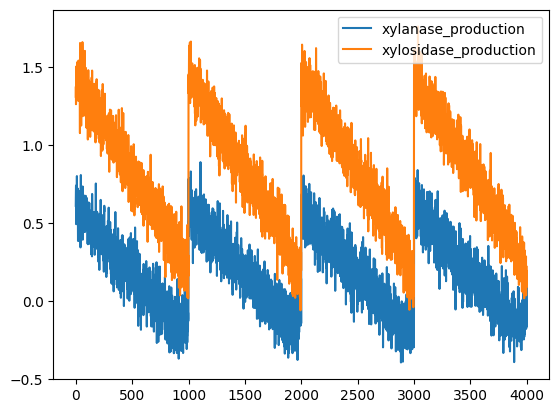

In [45]:
pd.DataFrame(actions["Bacllus_agent1"],columns=["xylanase_production","xylosidase_production"]).plot()

In [112]:
with open("/Users/parsaghadermarzi/Desktop/Academics/Projects/SPAM-DFBA/examples/Results/Bacillus_168_Xylan/Bacillus_168_Xylan_200.pkl","rb") as f:
    env=pickle.load(f)

In [59]:
from spamdfba import toolkit as tk

In [67]:
env.initial_condition[232]=1

10.0

In [68]:
obs=tk.rollout(env)

In [71]:
data=pd.DataFrame(obs[0]["Bacllus_agent1"],columns=['Bacllus_agent1' ,"xyl__D_e", 'Xylan','time_left'])

In [72]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=data.index,y=data["xyl__D_e"],mode="lines",name="Xylose"))
fig.add_trace(go.Scatter(x=data.index,y=data["Xylan"],mode="lines",name="Xylan"))
fig.add_trace(go.Scatter(x=data.index,y=data["Bacllus_agent1"],mode="lines",name="Bacillus"))
fig.show()